In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer 
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score

In [9]:
# Defineing classes for transformations

class PKDKodWoEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, top_n=10, smoothing=0.5):
        self.top_n = top_n
        self.smoothing = smoothing
    
    def fit(self, X, y):
        # X jest tutaj DataFrame'em, nawet jeśli ma tylko jedną kolumnę
        X = X.copy()
        y = y.copy()
        
        # wybieramy top_n najczęstszych kategorii
        self.top_values_ = X['pkdKod'].value_counts().nlargest(self.top_n).index
        
        # kolumna w ktorej rzadkie wartosci zamieniamy na '0'
        grouped = X['pkdKod'].where(X['pkdKod'].isin(self.top_values_), other='0')
        
        # liczymy woe
        df = pd.DataFrame({'group': grouped, 'target': y})
        agg = df.groupby('group')['target'].agg(['sum', 'count'])
        agg = agg.rename(columns={'sum':'bad', 'count':'total'})
        agg['good'] = agg['total'] - agg['bad']

        agg['bad_s'] = agg['bad'] + self.smoothing
        agg['good_s'] = agg['good'] + self.smoothing

        total_bad = agg['bad_s'].sum()
        total_good = agg['good_s'].sum()

        agg['woe'] = np.log((agg['good_s'] / total_good) / (agg['bad_s'] / total_bad))

        self.woe_map_ = agg['woe'].to_dict()
        # Fallback dla kategorii, które mogłyby się pojawić tylko w teście (chociaż '0' powinno to łapać)
        self.fallback_ = agg.loc['0', 'woe'] if '0' in agg.index else np.mean(list(self.woe_map_.values()))
        
        return self
    
    def transform(self, X):
        X = X.copy()
        grouped = X['pkdKod'].where(X['pkdKod'].isin(self.top_values_), other='0')
        X['WoE_pkdKod_grouped'] = grouped.map(self.woe_map_).fillna(self.fallback_)
        return X.drop(columns=['pkdKod'])

class DropConstantColumns(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # znajdź kolumny, które mają tylko jedną unikalną wartość
        self.cols_to_drop_ = [col for col in X.columns if X[col].nunique() <= 1]
        return self

    def transform(self, X):
        return X.drop(columns=self.cols_to_drop_, errors='ignore')

class MissingValueIndicatorAndImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy="median"):
        self.strategy = strategy

    def fit(self, X, y=None):
        X = X.replace([np.inf, -np.inf], np.nan).copy()
        self.base_cols_ = list(X.columns)

        # kolumny do imputacji
        # USES SimpleImputer (now imported)
        self.imputer_ = SimpleImputer(strategy=self.strategy)
        self.imputer_.fit(X[self.base_cols_])

        # nazwy kolumn wskaźników
        self.indicator_cols_ = [f"{c}_mial_braki_danych" for c in self.base_cols_]

        return self

    def transform(self, X):
        X = X.replace([np.inf, -np.inf], np.nan).copy()

        # imputacja
        X_imputed = pd.DataFrame(
            self.imputer_.transform(X[self.base_cols_]),
            columns=self.base_cols_,
            index=X.index
        )

        # wskaźniki braków danych
        indicator_df = X[self.base_cols_].isna().astype(int)
        indicator_df.columns = self.indicator_cols_
        indicator_df.index = X.index

        # łączymy razem
        X_out = pd.concat([X_imputed, indicator_df], axis=1)

        return X_out


In [10]:
# Splitting data into train, validation, test

data = pd.read_csv("zbiór_10.csv")
X = data.drop(columns=["default"]) # data
y = data["default"] # target

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

Train: 2091, Val: 459, Test: 450


In [11]:
# WOE for PKDKod column on X,y_train and transforming all X

print("Fitting WoE Encoder...")
woe_encoder = PKDKodWoEEncoder(top_n=10, smoothing=0.5)

# Fit only on the training data
woe_encoder.fit(X_train, y_train)

# Transform all data splits
X_train_woe = woe_encoder.transform(X_train)
X_val_woe = woe_encoder.transform(X_val)
X_test_woe = woe_encoder.transform(X_test)

print("WoE encoding complete.")

Fitting WoE Encoder...
WoE encoding complete.


In [12]:
# Defineing pipeline for numerical and cathegorical columns separately and then joining

categorical_features = [
    'formaWlasnosci_Symbol', 
    'schemat_wsk_bilans', 
    'schemat_wsk_rzis'
]

numerical_features = [
    col for col in X_train_woe.columns if col not in categorical_features
]


numeric_transformer = Pipeline(steps=[
    ('missing', MissingValueIndicatorAndImputer(strategy="median")),
    ('drop_constant', DropConstantColumns()),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # reszta (nie powinno niczego być) zostaje po prostu
)

In [13]:
# Defineing model with early stopping parameter 

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=1000,
    learning_rate=0.05,
    eval_metric='auc',
    early_stopping_rounds=50,
    random_state=42,
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum() 
)

# Defineing pipeline

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])

In [14]:

print("Transforming validation data for early stopping...")
X_val_processed = pipeline['preprocessor'].fit(X_train_woe).transform(X_val_woe)

fit_params = {
    'model__eval_set': [(X_val_processed, y_val)],
    'model__verbose' : 100
}

print("Training the full pipeline with early stopping...")
pipeline.fit(X_train_woe, y_train, **fit_params)

print("Pipeline training complete.")

Transforming validation data for early stopping...
Training the full pipeline with early stopping...
[0]	validation_0-auc:0.69071
[94]	validation_0-auc:0.77072
Pipeline training complete.


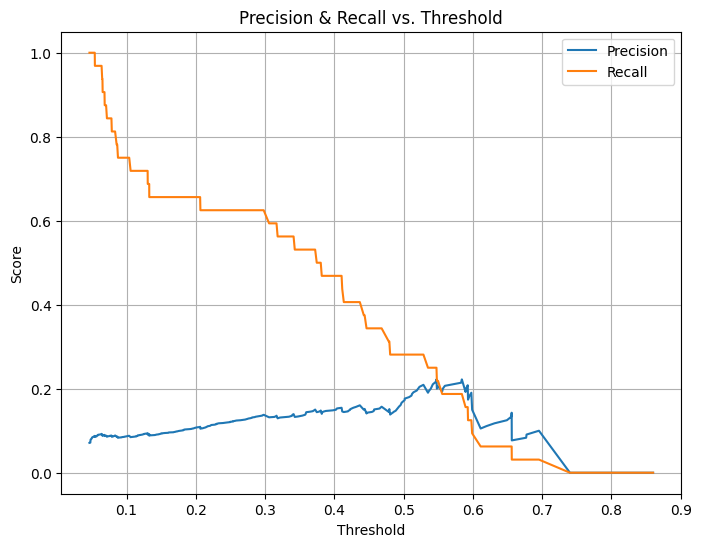


--- Optimal Threshold Finder ---
Best F1-Score: 0.2400
Found at Threshold: 0.5285

--- Model Evaluation ---
Test Accuracy: 0.8733
Best Iteration: 45
Best Score (Validation AUC): 0.7894

--- Classification Report (Threshold = 0.5285) ---
                precision    recall  f1-score   support

No Default (0)       0.94      0.92      0.93       418
   Default (1)       0.21      0.28      0.24        32

      accuracy                           0.87       450
     macro avg       0.58      0.60      0.59       450
  weighted avg       0.89      0.87      0.88       450

--- Confusion Matrix (Threshold = {best_threshold:.4f}) ---
[[384  34]
 [ 23   9]]


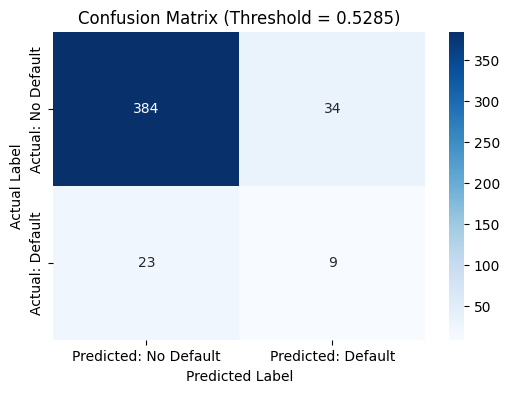

In [15]:
# Finding optimal threshold:
y_proba = pipeline.predict_proba(X_test_woe)[:, 1]


# plot
precision, recall, thresholds = precision_recall_curve(y_test, y_proba, pos_label=1)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision & Recall vs. Threshold')
plt.legend()
plt.grid()
plt.show()


# best choice
f1_scores = (2 * precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)

best_f1_index = np.argmax(f1_scores)

best_threshold = thresholds[best_f1_index]
best_f1_score = f1_scores[best_f1_index]

print(f"\n--- Optimal Threshold Finder ---")
print(f"Best F1-Score: {best_f1_score:.4f}")
print(f"Found at Threshold: {best_threshold:.4f}")


# wyciąganie prawdopodobienstw wiekszych rownych naszemu threshold
y_pred_best = (y_proba >= best_threshold).astype(int)


# printing parameters
accuracy = accuracy_score(y_test, y_pred_best)
print(f"\n--- Model Evaluation ---")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Best Iteration: {pipeline.named_steps['model'].best_iteration}")
print(f"Best Score (Validation AUC): {pipeline.named_steps['model'].best_score:.4f}")


# classification report
print(f"\n--- Classification Report (Threshold = {best_threshold:.4f}) ---")
print(classification_report(y_test, y_pred_best, target_names=['No Default (0)', 'Default (1)']))


# confusion matrix
print("--- Confusion Matrix (Threshold = {best_threshold:.4f}) ---")
cm = confusion_matrix(y_test, y_pred_best)
print(cm)


# heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted: No Default', 'Predicted: Default'], 
            yticklabels=['Actual: No Default', 'Actual: Default'])
plt.title(f'Confusion Matrix (Threshold = {best_threshold:.4f})')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()
plt.show()